In [ ]:
!python3 --version

Python 3.7.12


In [ ]:
!apt install libspatialindex-dev ## specjalna biblioteka do analiz przestrzennych na linux
!pip install geopandas ## biblioteka geopandas w pythonie
!pip install folium mapclassify ## potrzebne do utworzenia mapy interaktywnej

## doinstalowujemy nowe pakiety na potrzeby analiz przestrzennych
!pip install -U pysal urbanaccess pandana libpysal esda

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium ## folium.Map
import libpysal as ps ## wagi
import esda ## statystyka morana
import mapclassify
from splot.esda import lisa_cluster ## wykres: kartogram ze skupiskami
from splot.esda import moran_scatterplot ## wykres: wykres rozrzutu ze statystyką morana
%matplotlib inline

Zmieniamy wielkość wyświetlanych wykresów (ustwienia globalne)

In [ ]:
plt.rcParams['figure.figsize'] = [8, 8] ## wielkość wykresu

In [ ]:
pow_df = gpd.read_file(filename = "powiaty.shp", encoding = "utf-8")
pow_df = pow_df[["SP_ID", "jpt_kod_je", "jpt_nazwa_", "geometry"]]
pow_df.head(n = 2)

,SP_ID,jpt_kod_je,jpt_nazwa_,geometry
0,0,0226,powiat złotoryjski,"POLYGON ((269083.616 370884.075, 269164.192 37..."
1,1,0262,powiat Legnica,"POLYGON ((296226.609 372333.783, 296689.158 37..."


In [ ]:
pow_df.query("jpt_nazwa_ == 'powiat Poznań'")

,SP_ID,jpt_kod_je,jpt_nazwa_,geometry
346,346,3064,powiat Poznań,"POLYGON ((345943.177 513293.772, 346461.461 51..."


In [ ]:
pow_df.jpt_nazwa_[346]

'powiat Poznań'

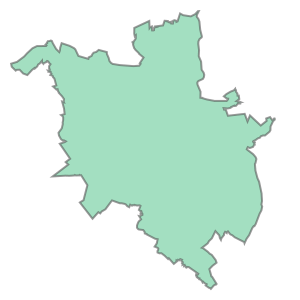

In [ ]:
pow_df.geometry[346]

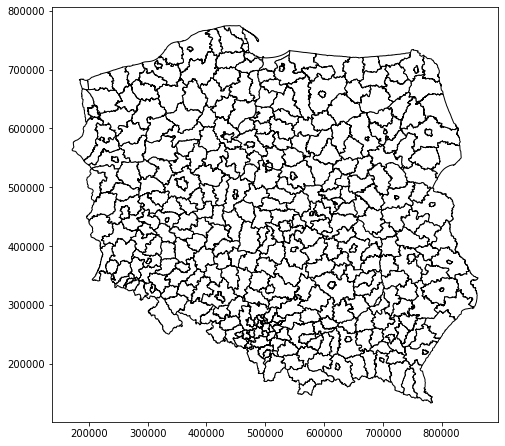

In [ ]:
pow_df.plot(color = "white", edgecolor = "black")

Dodaję informacje o przynależności danego powiatu do województwa, a następnie rysuję mapę województwa wielkopolskiego (30)

In [ ]:
pow_df["kod_woj"] = pow_df.jpt_kod_je.str.slice(stop = 2)
pow_df.head(n = 2)

,SP_ID,jpt_kod_je,jpt_nazwa_,geometry,kod_woj
0,0,0226,powiat złotoryjski,"POLYGON ((269083.616 370884.075, 269164.192 37...",02
1,1,0262,powiat Legnica,"POLYGON ((296226.609 372333.783, 296689.158 37...",02


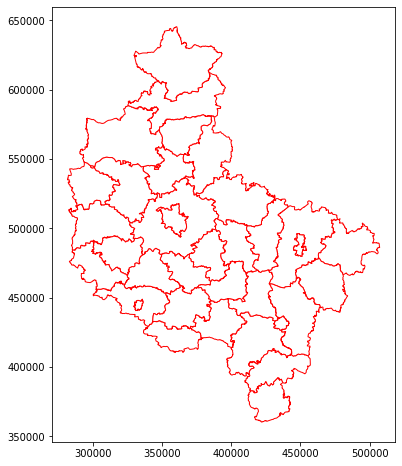

In [ ]:
pow_df.query("kod_woj == '30'").plot(color = "white", edgecolor = "red")

Interaktywna mapa 

In [ ]:
##pow_df.explore()

Mapa Poznania

In [ ]:
pzn = gpd.read_file(filename= 'Poznan.shp', encoding = 'utf-8')
pzn.head(n=3)

,ID,dzielnica,latdeg,longdeg,geometry
0,1,DASZEWICE,52.313859,16.952755,"POLYGON ((16.953 52.314, 16.953 52.314, 16.953..."
1,2,GŁUSZYNA II,52.340461,16.966497,"POLYGON ((16.966 52.340, 16.969 52.340, 16.969..."
2,3,ŁAWICA II,52.414490,16.799036,"POLYGON ((16.799 52.414, 16.799 52.415, 16.799..."


In [ ]:
pzn.crs

<Projected CRS: EPSG:2180>
Name: ETRF2000-PL / CS92
Axis Info [cartesian]:
- x[north]: Northing (metre)
- y[east]: Easting (metre)
Area of Use:
- name: Poland - onshore and offshore.
- bounds: (14.14, 49.0, 24.15, 55.93)
Coordinate Operation:
- name: Poland CS92
- method: Transverse Mercator
Datum: ETRF2000 Poland
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

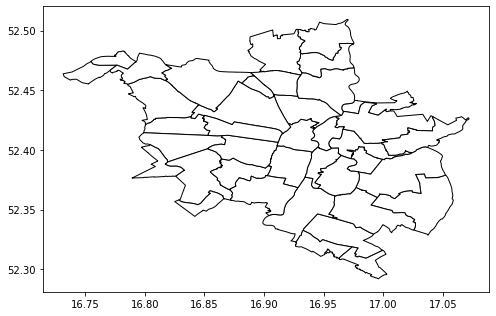

In [ ]:
pzn.plot(color = "white", edgecolor = "black")

Wczytujemy dane z pliku excela

In [ ]:
wynag = pd.read_excel(io = "powiaty_wynag.xlsx", sheet_name=1)
wynag = wynag[["Kod", "Wartosc"]]
wynag["kod"] = wynag.Kod.astype(str).str.zfill(7)
wynag["kod"] = wynag.kod.str.slice(start=0,stop=4)
wynag.head(n=2)

,Kod,Wartosc,kod
0,201000,4214.66,0201
1,202000,4024.94,0202


In [ ]:
pow_df_dane = pd.merge(left = pow_df, 
                       right = wynag[["kod", "Wartosc"]], 
                       how = "left",
                       left_on = "jpt_kod_je", 
                       right_on = "kod")
pow_df_dane.head(n=3)

,SP_ID,jpt_kod_je,jpt_nazwa_,geometry,kod_woj,kod,Wartosc
0,0,0226,powiat złotoryjski,"POLYGON ((269083.616 370884.075, 269164.192 37...",02,0226,4362.98
1,1,0262,powiat Legnica,"POLYGON ((296226.609 372333.783, 296689.158 37...",02,0262,4259.37
2,2,0206,powiat jeleniogórski,"POLYGON ((244044.051 332419.671, 244238.860 33...",02,0206,4035.56


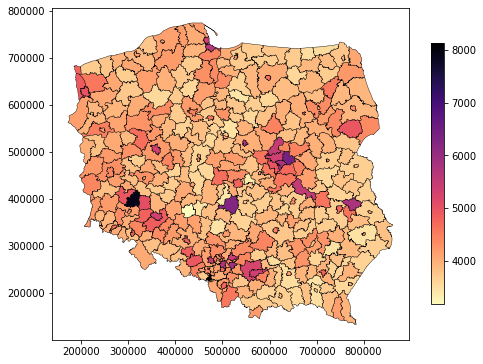

In [ ]:
pow_df_dane.plot(column = "Wartosc", cmap = "magma_r", 
                 legend = True, edgecolor = "black", 
                 linewidth = 0.4, legend_kwds = {'shrink': 0.6})

# Analizy przetrzenne 

## Wyznaczenie wag przestrzennych

In [ ]:
## dostajemy macierz 0-1
W = ps.weights.Queen.from_dataframe(pow_df_dane)
W.transform

/usr/local/lib/python3.7/dist-packages/libpysal/weights/_contW_lists.py:29: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(list(zip(*shape.coords.xy)) for shape in shape)))
/usr/local/lib/python3.7/dist-packages/libpysal/weights/_contW_lists.py:31: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(_get_boundary_points(part.boundary) for part in shape)))


'O'

In [ ]:
## dostajemy się do wyznaczonej macierzy
W.full()[0] ## wyświetlamy całą macierz

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
## wyświetlamy sąsiadów pierwszego obiektu (powiat złotoryjski)
W.full()[0][0,:]

array([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

Aby wystadaryzować macierz wierszowo musimy napisać następujący kod:

In [ ]:
W.transform = "r" ## standaryzacja wierszami
W.full()[0][:5,:5]

array([[0. , 0. , 0.2, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0.2, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ]])

In [ ]:
## wyświetlamy sąsiadów pierwszego obiektu (powiat złotoryjski)
W.full()[0][0,:]

array([0. , 0. , 0.2, 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. ,
       0.2, 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.

Wyznaczamy statystykę Morana I z wykorzystaniem modułu `esda`.

In [ ]:
stat_moran = esda.moran.Moran(pow_df_dane.Wartosc, W)
stat_moran.I ## wartość statystyki morana

0.23194481829022168

Interpretacja wyniku jest następująca: Statystyka Morana I jest większa od zera i wynosi 0.23 co oznacza, że autokorelacja przetrzenna wynagrodzeń jest dodatnia. Oznacza to, że powiaty o podobnej sytuacji grupują się.

In [ ]:
stat_moran.p_norm ## p-value

6.1948224328034485e-12

In [ ]:
stat_moran.seI_norm ## błąd standardowy

0.03412074183220515

Wyznaczamy statystykę Morana I samodzielnie korzystając z następującego wzoru:

$$
I = \frac{\mathbf{z}^T \mathbf{W}^*\mathbf{z} }{\mathbf{z}^T \mathbf{z}}
$$

In [ ]:
## różnica między wartościami obserwowanymi a średnią (y_i - bar{y})
z = pow_df_dane.Wartosc - np.mean(pow_df_dane.Wartosc)
## macierz standaryzowana wierszami
W_star = W.full()[0]
## wyznaczami I zgodnie z powyższym wzorem
I_recznie = (np.transpose(z) @ W_star @ z) / (np.transpose(z) @ z) # %*%
I_recznie

0.23194481829022168

## Lokalne statystyki Morana

In [ ]:
np.random.seed(1)
lokalny_moran = esda.moran.Moran_Local(pow_df_dane.Wartosc, W)
lokalny_moran

+ `Is` -- lokalne miary Morana (dla każdej jednostki)
+ ``

In [ ]:
np.mean(lokalny_moran.Is), np.std(lokalny_moran.Is)

(0.23133443718945804, 0.7269806009398164)

In [ ]:
np.sum(lokalny_moran.p_z_sim < 0.05)

59

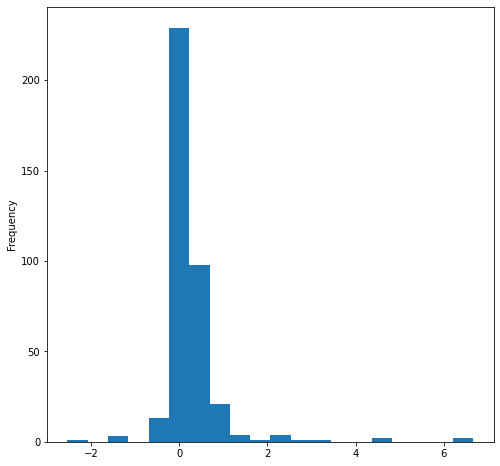

In [ ]:
pow_df_dane["moran2"] = pd.DataFrame(lokalny_moran.Is)
pow_df_dane.moran2.plot.hist(bins = 20)

In [ ]:
pow_df_dane.sort_values(by = "moran2",  ascending=True)

,SP_ID,jpt_kod_je,jpt_nazwa_,geometry,kod_woj,kod,Wartosc,moran,moran2
63,63,1001,powiat bełchatowski,"POLYGON ((489945.770 380441.322, 492229.268 38...",10,1001,6259.40,-2.541727,-2.541727
86,86,0610,powiat łęczyński,"POLYGON ((754987.929 395734.203, 755092.845 39...",06,0610,5772.29,-1.590663,-1.590663
271,271,2415,powiat wodzisławski,"POLYGON ((445512.207 243158.664, 445547.467 24...",24,2415,3725.84,-1.489296,-1.489296
276,276,2467,powiat Jastrzębie-Zdrój,"POLYGON ((465163.252 230038.515, 465227.497 23...",24,2467,8121.08,-1.280717,-1.280717
165,165,1462,powiat Płock,"POLYGON ((542338.336 517151.085, 542367.493 51...",14,1462,5705.32,-0.694060,-0.694060
...,...,...,...,...,...,...,...,...,...
28,28,0211,powiat lubiński,"POLYGON ((291305.112 387732.614, 291371.123 38...",02,0211,7915.01,3.336063,3.336063
163,163,1432,powiat warszawski zachodni,"POLYGON ((589499.227 491374.400, 589712.962 49...",14,1432,5375.27,4.467491,4.467491
143,143,1465,powiat Warszawa,"POLYGON ((626505.916 483271.600, 626528.812 48...",14,1465,6432.78,4.529169,4.529169
150,150,1421,powiat pruszkowski,"POLYGON ((611505.919 478928.219, 611697.703 47...",14,1421,5757.06,6.337780,6.337780


Wizualizujemy skupiska powiatów na podstaiwe lokalnej statystyki Moran'a.

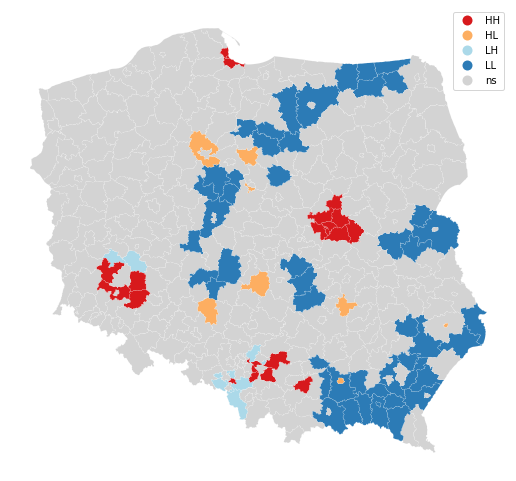

In [ ]:
lisa_cluster(lokalny_moran, pow_df_dane, p = 0.05, figsize = (9,9))
plt.show()

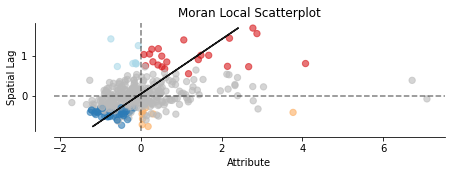

In [ ]:
fig, ax = moran_scatterplot(lokalny_moran, p = 0.05)
plt.show()